In [195]:
import os
import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import repeat, chain, product
from tdigest import TDigest

In [74]:
# def get_order(reaches, order):
#     # Make sorted list of bins present
#     widths = []
#     reach_bins = list(set(reaches[binn].to_list()))

#     for i in order:
#         if i in reach_bins:
#             widths.append(i)
            
#     return widths

In [144]:
def prepDict(data_dict, widths, thresholds):
    '''
    '''
    for width in widths:
        temp_dict = {}
        for threshold in thresholds:
            temp_dict[threshold] = TDigest()
        data_dict[width] = temp_dict
        
    return data_dict

In [168]:
def subset_coverage(df, widths, thresholds, bbin):
    # Create a MultiIndex using the Cartesian product of widths and thresholds
    combinations = pd.MultiIndex.from_product([widths, thresholds], names=['widths', 'thresholds'])
    
    # Group by 'widths' and 'thresholds' and get the 'coverage' for each group
    coverage_lists = (
        df.groupby([bbin, 'threshold'])['coverage']
        .apply(list)
        .reindex(combinations, fill_value=[])
        .tolist()
    )
    
    return coverage_lists

In [197]:
def read_output(data_path, data_dict, widths, thresholds, bbin):
    '''
    '''
    combos = list(product(widths, thresholds))
    
    # Get list of files    
    files = []
    for file in os.listdir(data_path):
        if not file.startswith('.'):
            if 'thresh' in file:
                files.append(file)

    num_files = str(len(files))
    
    # Read in file
    for i, file in enumerate(files):
        df = pd.read_parquet(os.path.join(data_path, file))
        
        coverage_lists = subset_coverage(df=df, widths=widths,
                                         thresholds=thresholds, bbin=bbin)
        
        for (width, threshold), coverage in zip(combos, coverage_lists):
            if len(coverage) != 0:
                data_dict[width][threshold].batch_update(values=coverage)
                data_dict[width][threshold].compress()
                    
        if i % 250 == 0:
            print(str(i) + ' of ' + num_files)

    return data_dict

In [111]:
## Setup

In [140]:
# Order of all possible bins for plotting
widths = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]', '(500, 1000]']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [127]:
## Setup
bwidth = 'min'
bbin = 'Bin_Min'
data_path = '../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_01_2025_03_02_' + bwidth

## Get data

In [190]:
digest_dict = prepDict(data_dict={}, widths=widths, thresholds=thresholds)

In [198]:
start = time.time()

data_min = read_output(data_path=data_path, data_dict=digest_dict,
                       widths=widths, thresholds=thresholds, bbin=bbin)

end = time.time()df
print(end-start)

0 of 3450
250 of 3450
500 of 3450
750 of 3450
1000 of 3450
1250 of 3450
1500 of 3450
1750 of 3450
2000 of 3450
2250 of 3450
2500 of 3450
2750 of 3450
3000 of 3450
3250 of 3450
928.8299467563629


In [229]:
data_min['(200, 500]'][0.1].centroids_to_list()

[]

In [232]:
medians = {}

for width in widths:
    temp = []
    for threshold in thresholds:
        test = data_min[width][threshold].centroids_to_list()
        if len(test) != 0:
            temp.append(data_min[width][threshold].percentile(50))
    medians[width] = temp

In [236]:
def remove_empty_values(input_dict):
    return {k: v for k, v in input_dict.items() if v}

In [237]:
medians = remove_empty_values(medians)

In [238]:
df_min_median = pd.DataFrame.from_dict(medians)

In [289]:
df_min_median*100

,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]","(100, 150]","(150, 200]"
0,2.977123,7.178544,12.815916,23.709608,30.766284,39.695071,79.408810,64.926290,91.936161,78.291551,83.028391,91.556693
1,2.564364,6.263702,9.386818,15.276209,20.781795,26.636738,66.923788,50.104423,90.035721,65.661605,67.650964,90.167914
2,2.211176,5.494714,8.455496,9.808468,13.687307,17.233115,55.635922,37.534332,80.219570,54.148936,52.122517,80.376851
3,1.924366,4.837475,7.639436,8.823195,9.693377,10.252203,44.309194,26.056180,68.022130,42.990142,37.564489,66.834264
4,1.689290,4.264725,6.867491,7.898592,8.894505,9.163599,33.526238,16.318962,52.551495,32.376138,23.471412,50.530035
5,1.489271,3.736318,6.082538,6.953149,8.052191,8.325410,22.324278,9.697451,36.504854,21.379004,11.160673,30.557554
6,1.313475,3.222408,5.201984,5.924835,7.052314,7.298189,11.842020,8.440901,19.843173,10.547550,8.481132,14.323353
7,1.150867,2.669124,4.118976,4.627678,5.636135,5.901675,8.012188,6.859794,8.761973,8.086349,6.615628,8.249583
8,0.982806,2.007554,2.725378,2.897505,3.611395,3.651069,4.624376,4.313212,4.452510,4.959198,3.910371,5.143468


In [306]:
def getCDF(width, thresholds, centiles):
    df_list = []
    
    for threshold in thresholds:
        w = []
        t = []
        cov = []
        for centile in centiles:
            test = data_min[width][threshold].centroids_to_list()
            if len(test) != 0:
                w.append(width)
                t.append(threshold)
                cov.append(data_min[width][threshold].percentile(centile))
        data = {'width': w, 'threshold': t, 'coverage': cov, 'centiles': centiles}
        df_list.append(pd.DataFrame(data))

    return pd.concat(df_list, axis=0, ignore_index=True)

In [303]:
thresh_subset = [0.1, 0.3, 0.5, 0.7, 0.9]

In [304]:
centiles = np.arange(1,101,1)

In [320]:
d = []
for w in df_min_median.columns:
    d.append(getCDF(width=w, thresholds=thresh_subset, centiles=centiles))
    
df_subset = pd.concat(d, axis=0, ignore_index=True)

In [321]:
df_subset

,width,threshold,coverage,centiles
0,"(0, 10]",0.1,-0.089360,1
1,"(0, 10]",0.1,-0.086928,2
2,"(0, 10]",0.1,-0.084497,3
3,"(0, 10]",0.1,-0.082066,4
4,"(0, 10]",0.1,-0.079635,5
...,...,...,...,...
5995,"(150, 200]",0.9,0.926871,96
5996,"(150, 200]",0.9,0.958514,97
5997,"(150, 200]",0.9,0.990158,98
5998,"(150, 200]",0.9,1.000000,99


In [273]:
# point_one = getCDF(threshold=0.1, widths=widths,
#                    centiles=centiles)

In [274]:
# point_one = remove_empty_values(point_one)

In [275]:
# df_min_ten = pd.DataFrame.from_dict(point_one)

In [284]:
# df_min_ten = df_min_ten*100

In [313]:
# df_min_ten.T

### Plots

In [314]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [315]:
cmap = plt.get_cmap('cubehelix')
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [261]:
widths[:-2]

['(0, 10]',
 '(10, 20]',
 '(20, 30]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]',
 '(70, 80]',
 '(80, 90]',
 '(90, 100]',
 '(100, 150]',
 '(150, 200]']

Text(0, 0.5, 'Detected [%]')

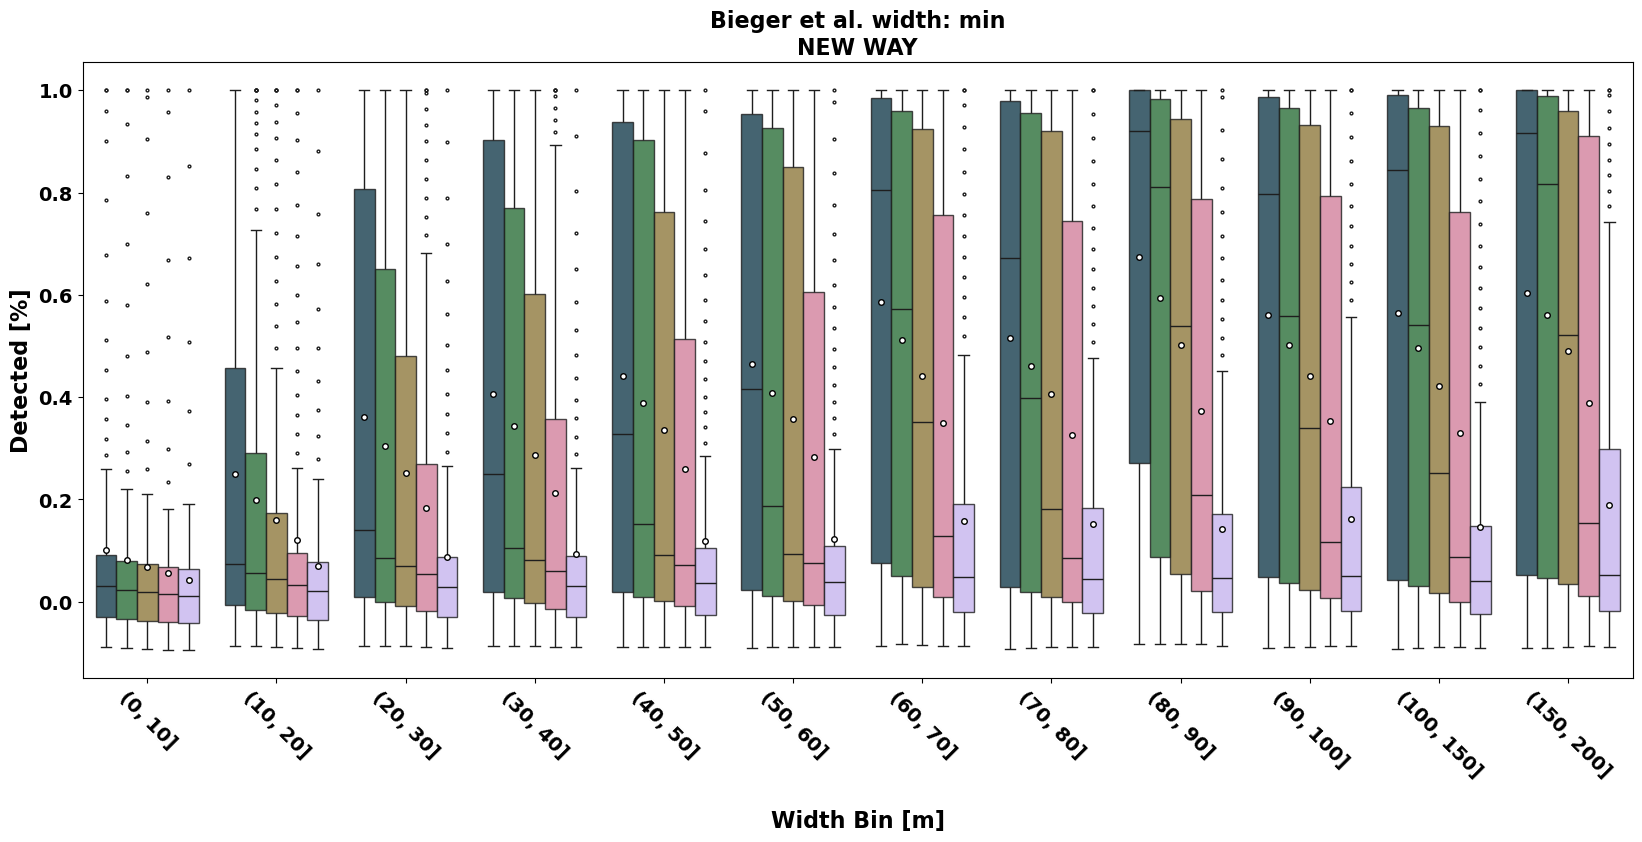

In [332]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(x='width', y='coverage', hue='threshold',
            data=df_subset, 
            palette=new_cmap,
            saturation=1, showmeans=True,
            fliersize=2, legend=False,
            boxprops=dict(alpha=0.8),
            meanprops={'marker':'o',
                       'markerfacecolor':'white',
                       'markeredgecolor':'k',
                       'markersize':'4'})

plt.title('Bieger et al. width: ' + bwidth + '\nNEW WAY', fontsize=16,
           fontweight='bold')

plt.xticks(fontsize=14, fontweight='semibold', rotation=-45)
plt.yticks(fontsize=14, fontweight='semibold',)

plt.xlabel('Width Bin [m]', fontsize=16,
           fontweight='bold', labelpad=20)
plt.ylabel('Detected [%]', fontsize=16,
           fontweight='bold')
